# Setup

In [2]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import os
from tqdm import tqdm
import requests
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt

In [18]:
data_path = pathlib.Path().resolve().parent.parent / "data"
rlpolk_data_path = data_path / "rlpolk_data"
vin_matching_path = data_path / "vin_matching"

# 1. Import Raw RLPolk Data

In [24]:
raw_rlpolk_data = pd.read_csv(rlpolk_data_path / "US_Yale_University_OP0001562727_NV_CT_VIN_Prefix_202212.txt", sep = '|')

# 1. Prepare CT NV Registrations Data

In [25]:
raw_rlpolk_data["VEH_COUNT"].sum()

975076

## 1a. Initial Descriptives - CT NV Registration Data

In [26]:
max_date = max(raw_rlpolk_data["everREPORT_YEAR_MONTH"])
min_date = min(raw_rlpolk_data["everREPORT_YEAR_MONTH"])
print(f"The data goes from {min_date} to {max_date}")

The data goes from 201801 to 202212


In [27]:
len(raw_rlpolk_data)

924477

In [28]:
raw_rlpolk_data["VEH_COUNT"].sum()

975076

In [13]:
raw_rlpolk_data["YEAR"] = raw_rlpolk_data["everREPORT_YEAR_MONTH"].astype(str).str[:4]

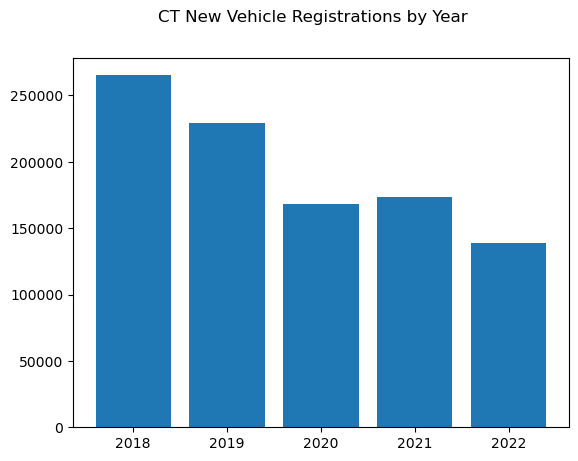

In [14]:
fig, ax = plt.subplots(nrows =1, ncols = 1)

ax.bar(x = "YEAR",
        height = "VEH_COUNT",
        data = raw_rlpolk_data[["YEAR", "VEH_COUNT"]].groupby("YEAR").sum().reset_index())

fig.suptitle("CT New Vehicle Registrations by Year")

plt.show()

## 1b. Change VIN format to match with NHTSA

In [56]:
raw_rlpolk_data["vin_corrected"] = raw_rlpolk_data["VIN_PREFIX"].str[0:8]+"*"+raw_rlpolk_data["VIN_PREFIX"].str[9:10]

# 2. Prepare NHTSA VIN dataset

In [58]:
vin_lookup = pd.read_csv(vin_matching_path / "all_vins_nhtsa.csv", index_col = [0]).reset_index(drop=True)
vin_lookup["vin_corrected"] = vin_lookup["vin_corrected"].str[0:10]
vin_lookup = vin_lookup.drop_duplicates(subset = "vin_corrected")

162685

# 3. Match

In [64]:
rlpolk_matched["Model"].isna().sum() / 924400

0.05111856339247079

In [59]:
# Match
rlpolk_matched = raw_rlpolk_data.merge(vin_lookup,
                                       how = 'left',
                                       right_on = 'vin_corrected',
                                       left_on = 'vin_corrected')
# Test the match worked
if len(rlpolk_matched) == len(raw_rlpolk_data):
    print("The matched DF is of the same length: success!")

The matched DF is of the same length: success!


# 4. Query NHTSA API to get more

In [68]:
unmatched_vins = rlpolk_matched[rlpolk_matched["Model"].isna()]["vin_corrected"].unique().tolist()
print(f"Thus there are {len(unmatched_vins)} unique unmatched VINs remaining")

Thus there are 3130 unique unmatched VINs remaining


In [74]:
def fetch_unmatched_vin(unmatched_vin):
        """
        Input: An unmatched, but corrected VIN
        Output: A matched VIN or NA
        
        """
        variables = ["Manufacturer Name", "Model", "Model Year", "Fuel Type - Primary", "Electrification Level"]
        
        url = (f"https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVin/{unmatched_vin.strip()}?format=csv")

        # Download response
        resp_df = pd.read_csv(url)

        # Extract needed
        resp_df = resp_df.loc[resp_df["variable"].isin(variables), ["variable", "value"]].T
        resp_df.columns = resp_df.iloc[0]
        resp_df = resp_df.drop("variable", axis = 0)
        resp_df["vin_corrected"] = unmatched_vin
        
        return resp_df

In [ ]:
nhtsa_queries = pd.DataFrame([])

In [77]:
for vin in tqdm(unmatched_vins[633:]):
    nhtsa_queries = pd.concat([nhtsa_queries, fetch_unmatched_vin(vin)]).reset_index(drop=True)

100%|██████████| 2497/2497 [09:50<00:00,  4.23it/s]


In [80]:
vin_lookup = pd.concat([vin_lookup, nhtsa_queries.reset_index(drop=True)]).reset_index(drop =True)

In [82]:
vin_lookup = vin_lookup.drop_duplicates(subset = "vin_corrected")

In [81]:
vin_lookup.to_csv(vin_matching_path / "all_vins_nhtsa.csv")

## Rematch

In [83]:
# Match
rlpolk_matched = raw_rlpolk_data.merge(vin_lookup,
                                       how = 'left',
                                       right_on = 'vin_corrected',
                                       left_on = 'vin_corrected')
# Test the match worked
if len(rlpolk_matched) == len(raw_rlpolk_data):
    print("The matched DF is of the same length: success!")

The matched DF is of the same length: success!


In [87]:
rlpolk_matched["Manufacturer Name"].isna().sum()

18

## Save

In [88]:
rlpolk_matched.to_csv(rlpolk_data_path / "rlpolk_data_matched.csv")